# Gaussian Process Regressor 

In [1]:
# Gaussian Process Regressor는 supervised learning에서 kernel regression 모델을 통해
# target function을 추론하는 Bayesian 방법론입니다. 

# 다변량 정규분포가 평균 벡터와 공분산 행렬로 표현되는 것처럼, GP 또한 평균 함수와 공분산 함수를 통해 다음과 같이 정의된다.
# P(x,y) ~ N ([μx, μy], [[Σx, Σxy], [Σxy.T, Σy]])       # 어떤 평균과 공분산을 가진 distribution에서 sampling
# P(X) ~ GP(m(t), k(x1, x2))                            # 어떤 평균과 Kernel을 가진 distributional function에서 sampling


# 상세 구현을 위해 우선적으로 kernel 함수를 정의합니다. 
# kernel 함수는 데이터 샘플 간의 유사도를 측정하는데 사용됩니다. 
# 이번 경우는 Radial Basis Function(RBF) kernel 함수를 사용합니다.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

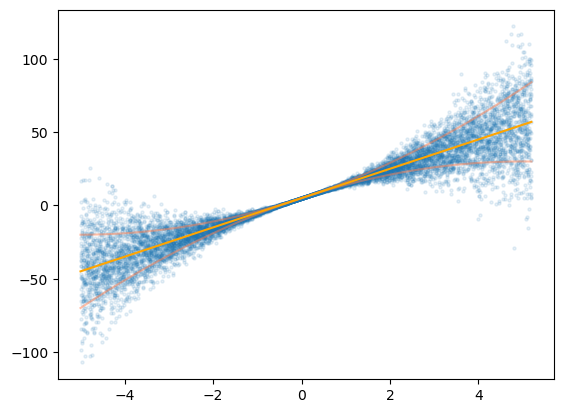

In [3]:
# Gaussian Process Concept_1
def func(x):
    return 10*x + 5

def variance(x):
    return x**2

def variance_func(x):
    return x**2*np.random.randn(len(x))

def gpr(x):
    return func(x) + variance_func(x)


xs = np.arange(-5, 5.2, 0.001)
plt.scatter(xs, gpr(xs), alpha=0.1, s=5)
plt.plot(xs, func(xs)+variance(xs), color='coral', alpha=0.5)
plt.plot(xs, func(xs)-variance(xs), color='coral', alpha=0.5)
plt.plot(xs, func(xs), color='orange')

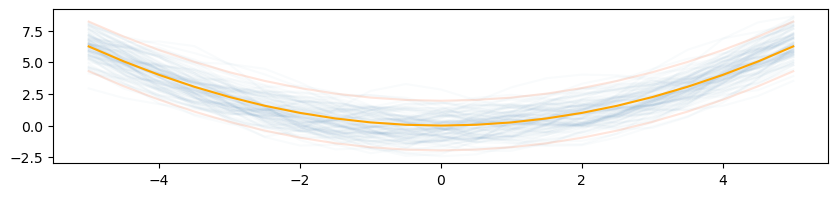

In [4]:
# Gaussian Process Concept_2

# xs = (-5:0.2:5); ns = size(xs,1); keps = 1e-9;
# m = inline('0.25*x.^2');
# K = inline('exp(-0.5*(repmat(p'',size(q))-repmat(q,size(p''))).^2)');
# fs = m(xs) + chol(K(xs,xs)+keps*eye(ns))*randn(ns,1);
# plot(xs,fs,'.')

import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(-5, 5.2, 0.5)
# xs = np.arange(-5, 5.0001, 0.)


def m(xi):
    return 0.25 * xi**2

def K(xi, xj):
    return np.exp(-1/2 * (xi.reshape(-1,1) - xj.reshape(-1,1).T)**2) 

def gaussian_random_function(xi, keps=1e-9, random_state=None):
    rng = np.random.RandomState(random_state)
    ns = len(xs)
    cov = K(xi, xi)

    # eigen decomposition
    # val, vec = np.linalg.eig(cov + keps * np.eye(ns))
    # fs = m(xi).ravel() + vec @ np.sqrt(np.diag(val)) @ rng.randn(ns)

    # cholesky decomposition
    L = np.linalg.cholesky(cov + keps * np.eye(ns))
    fs = m(xi).ravel() + L @ rng.randn(ns)
    
    return fs

kernel = K(xs, xs) 
variance = np.sqrt(np.diag(kernel))


plt.figure(figsize=(10,2))
for i in range(100):
    plt.plot(xs, gaussian_random_function(xs, random_state=i), alpha=0.03, color='steelblue')
    # plt.plot(xs, np.random.multivariate_normal(mean=m(xs), cov=K(xs, xs)), alpha=0.03, color='steelblue')
plt.plot(xs, m(xs) + 1.96*variance, color='coral',alpha=0.2)
plt.plot(xs, m(xs) - 1.96*variance, color='coral',alpha=0.2)
plt.plot(xs, m(xs), color='orange')
plt.show()



### Gaussian Process Regressor Code

In [7]:
# https://greeksharifa.github.io/bayesian_statistics/2020/07/12/Gaussian-Process/
# https://aistory4u.tistory.com/entry/%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%ED%94%84%EB%A1%9C%EC%84%B8%EC%8A%A4-%ED%9A%8C%EA%B7%80
# https://pasus.tistory.com/209
# https://october25kim.github.io/paper/kernel%20method/2020/10/31/gpr-paper/

In [6]:
# dataset
X_truth = np.linspace(-4, 4, 101).reshape(-1,1)
y_truth = np.sin(X_truth)
idx = np.arange(101)

# rng.choice(idx, )

rng = np.random.RandomState(0)
X_all = X_truth.copy()
y_all = y_truth.copy()

# random noise 추가
noise = True
if noise is True:
    noise_amp = 0.3
    # noise = rng.randn(len(y_all)).reshape(-1,1) * noise_amp
    noise = rng.normal(0, noise_amp, size=len(y_all)).reshape(-1,1)
    y_all = y_all + noise

n_sample = 10
train_idx = rng.choice(idx, n_sample)


X = X_all[train_idx]
y = y_all[train_idx]

X_train = X.reshape(-1,1)
y_train = y.reshape(-1,1)

print(X_train.shape, y_train.shape)


(10, 1) (10, 1)


In [5]:
class RBF_Kernel():
    def __init__(self, sigma_f=(2*np.pi)**(-1/4), l=1, corr=0, const=0):
        self.sigma_f = (2*np.pi)**(-1/4) if sigma_f is None else sigma_f    # (default) 0.63161877
        self.l = 1 if l is None else l
        self.corr = 0 if corr is None else corr
        self.const = 0 if const is None else const
        
        
    
    def kernel(self, X1, X2):
        """ 
        :param X1: numpy array, (n_samples_1, n_features) 
        :param X2: numpy array, (n_samples_2, n_features) 
        :param l: float, length parameter 
        :param sigma_f: float, scaling parameter 
        :return: numpy array, (n_samples_1, n_samples_2) 
        """ 
        n_samples_1, n_features = X1.shape 
        n_samples_2, n_features = X2.shape 
        
        K = np.zeros((n_samples_1, n_samples_2)) 
        
        for i in range(n_samples_1): 
            for j in range(n_samples_2): 
                diff = X1[i] - X2[j] 
                K[i, j] = self.sigma_f ** 2 * np.exp(-1 / (2 * self.l**2) * np.dot(diff.T, diff)) + self.corr*X1[i]*X2[j] + self.const
                # K(x1, x2) = σf² · exp( 1/(2σl²) ·(x1 - x2).T@(x1 - x2) ) + correlation*x1*x2 + constant
        return K 
    
    def __call__(self, X1, X2):
        return self.kernel(X1, X2)


class Polynomial_Kernel():
    def __init__(self, order=1, sigma_f=None):
        self.order = order
        self.sigma_f = 1 if sigma_f is None else sigma_f     # (default) 1

    def kernel(self, X1, X2):
        polynomial_X1 = np.ones((len(X1), self.order+1))
        polynomial_X2 = np.ones((len(X2), self.order+1))
        for i in range(self.order):
            polynomial_X1[:,[-(i+2)]] = X1**(i+1)
            polynomial_X2[:,[-(i+2)]] = X2**(i+1)
        # return polynomial_X1, polynomial_X2
        return self.sigma_f * (polynomial_X1 @ polynomial_X2.T)

    def __call__(self, X1, X2):
        return self.kernel(X1, X2)

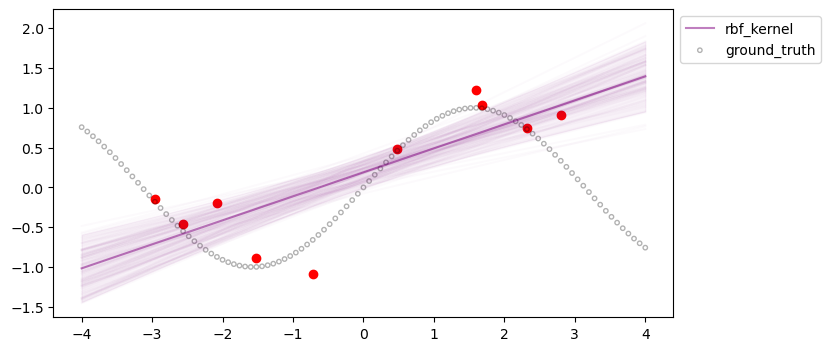

In [10]:
## [ Polynomial Kernel (1st Order)] ########################################################################
X_data = X_all.copy()
y_data = y_all.copy()

# Polynomial Kernel (1st Order) ***
sigma_f = None
beta = 1e-1
kernel = Polynomial_Kernel(1, sigma_f)

train_cov = kernel(X_train, X_train) + beta*np.eye(len(X_train))
traintest_cov = kernel(X_train, X_data)
test_cov = kernel(X_data, X_data) + 1e-10

mu = traintest_cov.T @ np.linalg.inv(train_cov) @ y_train
cov = test_cov - traintest_cov.T @ np.linalg.inv(train_cov) @ traintest_cov
std = np.sqrt(np.diag(cov).reshape(-1,1))


# (Visualization)
f = plt.figure(figsize=(8,4))
# Observation
plt.scatter(X_train, y_train, color='red')

# RBF_Kernel
plt.plot(X_data, mu, color='purple', alpha=0.5, label='rbf_kernel')
plt.fill_between(X_data.ravel() ,( mu - 1.96*std ).ravel(), ( mu + 1.96*std ).ravel()
                ,alpha=0.05, color='purple')
for _ in range(100):
    sample_function = np.random.multivariate_normal(mu.ravel(), cov)
    plt.plot(X_data, sample_function, color='purple', alpha=0.02)

# Ground Truth
plt.scatter(X_truth, y_truth, edgecolor='black', s=10, facecolor='None', alpha=0.3, label='ground_truth')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


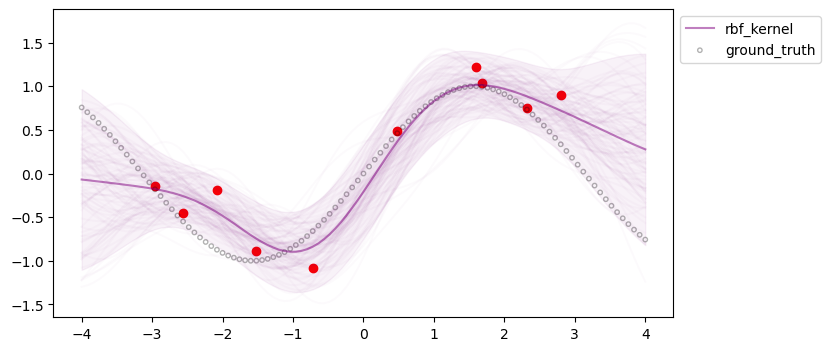

In [13]:
## [ Gaussian Process ] ########################################################################
X_data = X_all.copy()
y_data = y_all.copy()

# RBF Kernel ***
sigma_f = None
l=None
beta = 1e-1     # error hyperparameter
kernel = RBF_Kernel(sigma_f, l)
# kernel = Polynomial_Kernel(4, sigma_f)

train_cov = kernel(X_train, X_train) + beta*np.eye(len(X_train))
traintest_cov = kernel(X_train, X_data)
test_cov = kernel(X_data, X_data) + 1e-10

mu = traintest_cov.T @ np.linalg.inv(train_cov) @ y_train
cov = test_cov - traintest_cov.T @ np.linalg.inv(train_cov) @ traintest_cov
std = np.sqrt(np.diag(cov).reshape(-1,1))

# # (sklearn gaussian process) ------------------------------------------------------------------------
# from sklearn.gaussian_process import GaussianProcessRegressor
# model_gpr = GaussianProcessRegressor(alpha=1e-2)
# # from sklearn.gaussian_process.kernels import RBF
# # kernel_RBF = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
# # model_gpr= GaussianProcessRegressor(kernel=kernel_RBF, alpha=1e-2)

# model_gpr.fit(X_train.reshape(-1,1), y_train)
# mu, std_ = model_gpr.predict(X_data, return_std=True)
# std = std_.reshape(-1,1)
# # ---------------------------------------------------------------------------------------------------



f = plt.figure(figsize=(8,4))
# Observation
plt.scatter(X_train, y_train, color='red')

# RBF_Kernel
plt.plot(X_data, mu, color='purple', alpha=0.5, label='rbf_kernel')
plt.fill_between(X_data.ravel() ,( mu - 1.96*std ).ravel(), ( mu + 1.96*std ).ravel()
                ,alpha=0.05, color='purple')
for _ in range(100):
    sample_function = np.random.multivariate_normal(mu.ravel(), cov)
    plt.plot(X_data, sample_function, color='purple', alpha=0.02)

# Ground Truth
plt.scatter(X_truth, y_truth, edgecolor='black', s=10, facecolor='None', alpha=0.3, label='ground_truth')
plt.legend(bbox_to_anchor=(1,1))
plt.show()


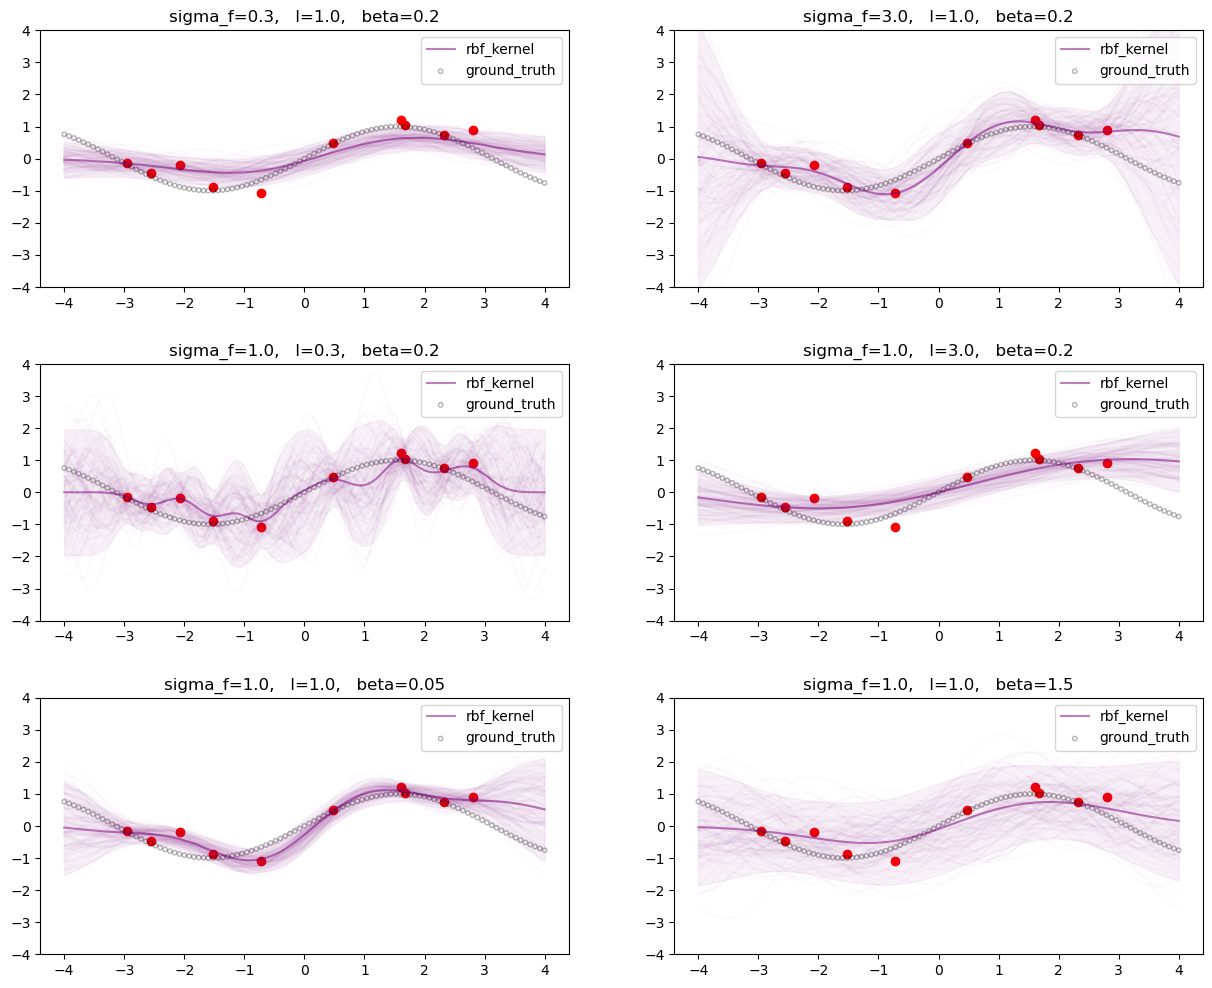

In [14]:
## [ GPR with several parameters ] ########################################################################
parameters = [
    #(sigma_f, l, beta)
     (0.3,   1.0,  0.2),
     (3.0,   1.0,  0.2),
     (1.0,   0.3,  0.2),
     (1.0,   3.0,  0.2),
     (1.0,   1.0,  0.05),
     (1.0,   1.0,  1.5),
    ]

f = plt.figure(figsize=(15,12))
for i, (sigma_f, l, beta) in enumerate(parameters):
    kernel = RBF_Kernel(sigma_f, l)
    # kernel = Polynomial_Kernel(4, sigma_f)

    train_cov = kernel(X_train, X_train) + beta*np.eye(len(X_train))
    traintest_cov = kernel(X_train, X_data)
    test_cov = kernel(X_data, X_data) + 1e-10

    mu = traintest_cov.T @ np.linalg.inv(train_cov) @ y_train
    cov = test_cov - traintest_cov.T @ np.linalg.inv(train_cov) @ traintest_cov
    std = np.sqrt(np.diag(cov).reshape(-1,1))

    # Plot
    plt.subplot(3,2,i+1)
    plt.title(f"sigma_f={sigma_f},   l={l},   beta={beta}")
    # Observation
    plt.scatter(X_train, y_train, color='red')

    # RBF_Kernel
    plt.plot(X_data, mu, color='purple', alpha=0.5, label='rbf_kernel')
    plt.fill_between(X_data.ravel() ,( mu - 1.96*std ).ravel(), ( mu + 1.96*std ).ravel()
                    ,alpha=0.05, color='purple')
    for _ in range(100):
        sample_function = np.random.multivariate_normal(mu.ravel(), cov)
        plt.plot(X_data, sample_function, color='purple', alpha=0.02)

    # Ground Truth
    plt.scatter(X_truth, y_truth, edgecolor='black', s=10, facecolor='None', alpha=0.3, label='ground_truth')
    plt.ylim(-4,4)
    plt.legend(loc='upper right')
    plt.subplots_adjust(hspace=0.3)
    
    # plt.legend(bbox_to_anchor=(1,1))
plt.show()

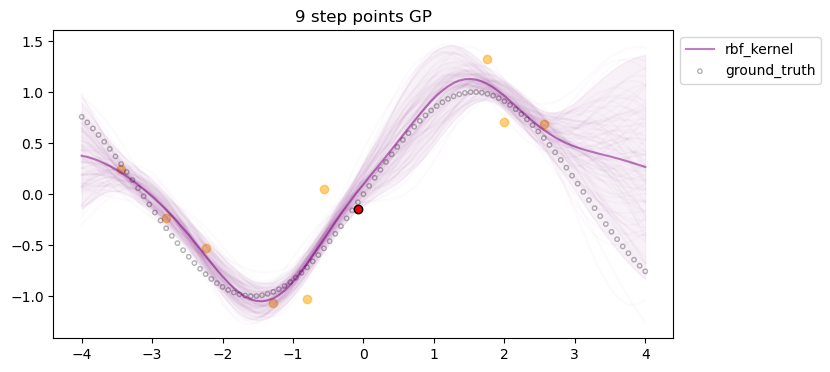

In [15]:
## [ Update Covariance Matrix ] ########################################################################
from IPython.display import clear_output
import time
# RBF Kernel ***
l=None
sigma_f = None
# beta = 1e-1     # error hyperparameter
beta = 1e-2     # error hyperparameter
kernel = RBF_Kernel(sigma_f, l)
# kernel = Polynomial_Kernel(4, sigma_f)


#####
# np.set_printoptions(suppress=True)
X_data = X_all.copy()
y_data = y_all.copy()

rng = np.random.RandomState(2)
idx_permuted = list(rng.permutation(idx))

sampled_idx = []
train_cov=None

plots = []
for i in range(10):
    sample = idx_permuted.pop()
    sampled_idx.append(sample)

    X_train = X_all[sampled_idx]
    y_train = y_all[sampled_idx]

    # train_covariance update
    # train_cov = kernel(X_train, X_train) + beta*np.eye(len(X_train))
    train_cov_ = np.zeros((len(X_train), len(X_train)))
    if train_cov is not None:
        train_cov_[0:len(X_train)-1,0:len(X_train)-1] = train_cov
    train_cov_[len(X_train)-1, len(X_train)-1] = kernel(X_train[[-1]], X_train[[-1]]) + beta
    train_cov_[:-1,len(X_train)-1] = kernel(X_train[:-1], X_train[[-1]]).T
    train_cov_[len(X_train)-1,:-1] = kernel(X_train[:-1], X_train[[-1]]).T
    train_cov = train_cov_

    traintest_cov = kernel(X_train, X_data)
    test_cov = kernel(X_data, X_data) + 1e-10

    mu = traintest_cov.T @ np.linalg.inv(train_cov) @ y_train
    cov = test_cov - traintest_cov.T @ np.linalg.inv(train_cov) @ traintest_cov
    std = np.sqrt(np.diag(cov).reshape(-1,1))


    f = plt.figure(figsize=(8,4))
    plt.title(f"{i} step points GP")
    # Observation
    plt.scatter(X_train, y_train, color='orange',alpha=0.5)
    plt.scatter(X_train[-1], y_train[-1], color='red', edgecolors='black')

    # RBF_Kernel
    plt.plot(X_data, mu, color='purple', alpha=0.5, label='rbf_kernel')
    plt.fill_between(X_data.ravel() ,( mu - 1.96*std ).ravel(), ( mu + 1.96*std ).ravel()
                    ,alpha=0.05, color='purple')
    for _ in range(100):
        sample_function = np.random.multivariate_normal(mu.ravel(), cov)
        plt.plot(X_data, sample_function, color='purple', alpha=0.02)
    # plt.plot(X_data, preds, color='mediumseagreen', alpha=0.5, label='gaussian')
    # plt.fill_between(X_data.ravel()
    #     ,preds.ravel()-1.96*stds
    #     ,preds.ravel()+1.96*stds
    #     , color='mediumseagreen', alpha=0.05)

    # Ground Truth
    plt.scatter(X_truth, y_truth, edgecolor='black', s=10, facecolor='None', alpha=0.3, label='ground_truth')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    plots.append(f)

    clear_output(wait=True)
    time.sleep(0.2)

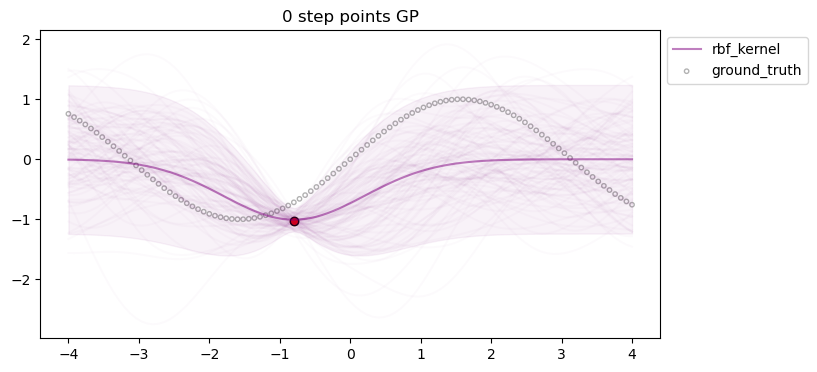

In [16]:
plots[0]

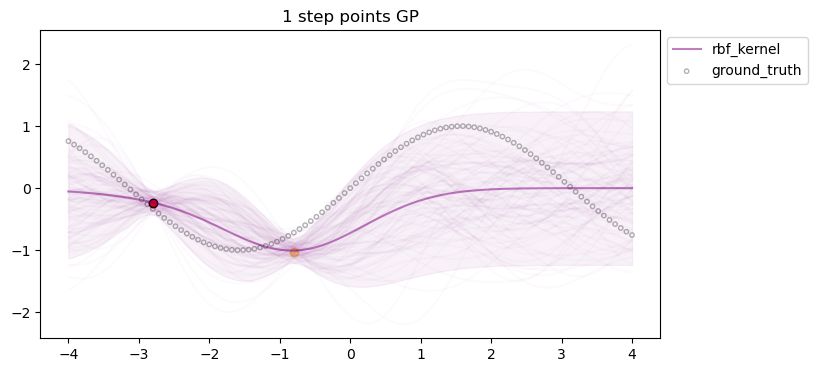

In [17]:
plots[1]

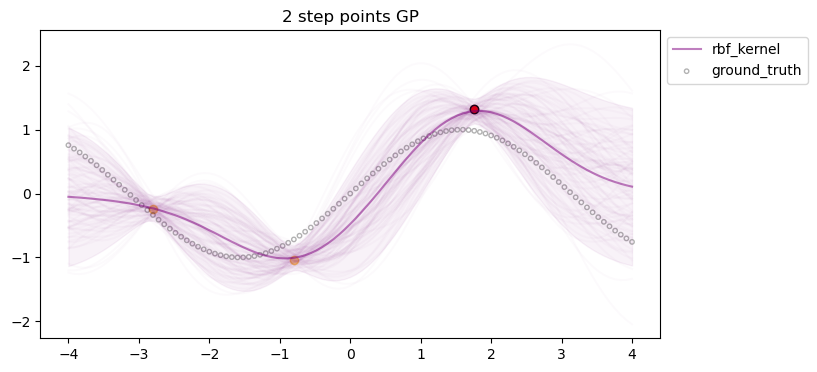

In [20]:
plots[2]

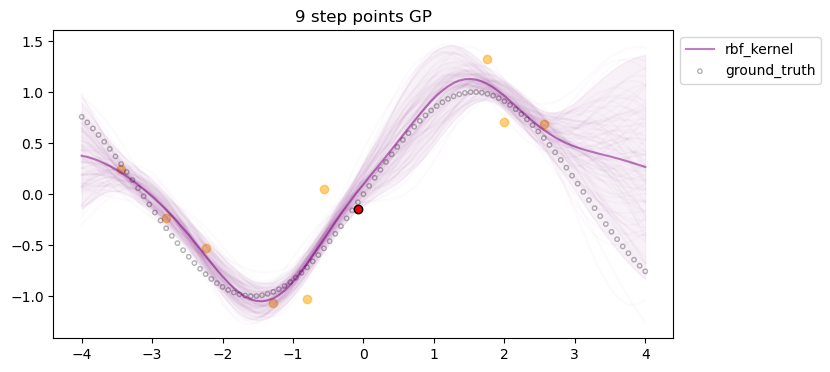

In [21]:
plots[-1]